In [7]:
import kagglehub
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import random
import re
import spacy
from tqdm import tqdm
import seaborn as sns
from collections import Counter
import numpy as np
from gensim.models import Word2Vec
import scipy.linalg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


#nltk.download('punkt_tab')

# Data Import

#### 0 is actually true and 1 is fake! The dataset poster made a mistake when transfering from the IEEE paper. Code below accounts for this mistake.

In [8]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/skim/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77


In [9]:
df = pd.read_csv('/Users/skim/VSCode/DIS Copenhagen/Computational Analysis of Big Data/Final Project/WELFake_Dataset.csv')
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


# Data Pre-processing

In [11]:
df = df.dropna(subset=['text'])  # Drop rows with null values in 'text' column
df = df.drop(columns=['Unnamed: 0'])  

df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [12]:
true_data = df[df['label'] == 0]
fake_data = df[df['label'] == 1]

print(true_data['label'].value_counts())
print(fake_data['label'].value_counts())

label
0    35028
Name: count, dtype: int64
label
1    37067
Name: count, dtype: int64


Remove the top and bottom 2% of articles by length. This is because some articles have barely any context and some articles are tens of thousands of words long. Fake and true are separated for statistics shown below.

In [13]:
combined_lengths = pd.concat([true_data['text'].apply(len), fake_data['text'].apply(len)])
percentile_2 = combined_lengths.quantile(0.02)
percentile_98 = combined_lengths.quantile(0.98)

# filter out the short and long
true_data_filtered = true_data[(true_data['text'].apply(len) >= percentile_2) & (true_data['text'].apply(len) <= percentile_98)]
fake_data_filtered = fake_data[(fake_data['text'].apply(len) >= percentile_2) & (fake_data['text'].apply(len) <= percentile_98)]

avg_filtered_true_length = true_data_filtered['text'].apply(len).mean()
avg_filtered_fake_length = fake_data_filtered['text'].apply(len).mean()


print(f"True data filtered count: {len(true_data_filtered)}, removed {len(true_data) - len(true_data_filtered)} articles.")
print(f"Fake data filtered count: {len(fake_data_filtered)}, removed {len(fake_data) - len(fake_data_filtered)} articles.\n")

print(f"Average length of filtered true articles: {avg_filtered_true_length}")
print(f"Average length of filtered fake articles: {avg_filtered_fake_length}\n")

print(f"Removed short articles below 2nd percentile of length < {percentile_2:.0f} characters.")
print(f"Removed long articles above 98th percentile of length > {percentile_98:.0f} characters.")

True data filtered count: 34433, removed 595 articles.
Fake data filtered count: 34789, removed 2278 articles.

Average length of filtered true articles: 3245.044492202248
Average length of filtered fake articles: 2714.814337865417

Removed short articles below 2nd percentile of length < 85 characters.
Removed long articles above 98th percentile of length > 12067 characters.


In [14]:
combined_df = pd.concat([true_data_filtered, fake_data_filtered])
combined_df

,title,text,label
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
11,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0
12,Schumer calls on Trump to appoint official to ...,"WASHINGTON (Reuters) - Charles Schumer, the to...",0
14,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0
15,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0
...,...,...,...
72121,Florida Judge Blames Rape Victim For Attendin...,The Ultra Music Festival in Miami is one of th...,1
72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1
72128,JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...,Judge Jeanine lets it rip! She s concerned wit...,1
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1


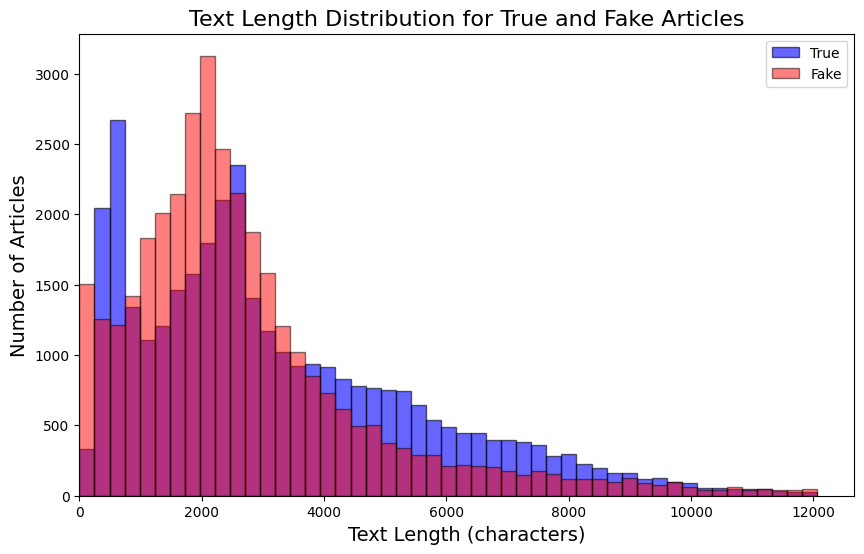

In [15]:
# Plot histogram to compare lengths true vs fake
true_lengths = true_data_filtered['text'].apply(len)
fake_lengths = fake_data_filtered['text'].apply(len)

max_length = max(true_lengths.max(), fake_lengths.max())
bins = np.linspace(0, max_length, 50)  # 50 bins between 0 and the max length

plt.figure(figsize=(10, 6))
plt.hist(true_lengths, bins=bins, color='blue', alpha=0.6, label='True', edgecolor='black')
plt.hist(fake_lengths, bins=bins, color='red', alpha=0.5, label='Fake', edgecolor='black')
plt.xlim(left=0)
plt.title("Text Length Distribution for True and Fake Articles", fontsize=16)
plt.xlabel("Text Length (characters)", fontsize=14)
plt.ylabel("Number of Articles", fontsize=14)
plt.legend()
plt.show()

We did a lot of exploration and attempts at removing the location and source from the start of true articles but we were not able to find an elegant way to do this and preserve the data well enough with all the possibilities for how this information was presented. thus we decided just to remove the first word if it is all caps and remove the mentioned news sources at the start

In [16]:
def preprocess_text(text):
    # Remove bolded location patterns, including:
    # - Single or multi-location with slashes (e.g., "LOCATION/LOCATION")
    # - Locations with states or abbreviations (e.g., "CAPE CANAVERAL, Fla")
    # - Locations followed by "(Reuters)", "(AP)", "—", or similar
    #text = re.sub(r"^[A-Z][A-Z\s,./]+(?:[A-Z][a-z]+)?(?: \(Reuters\)| \(CNN\)| \(AP\)|—|–)\s*-*\s*", "", text)
    
    # Handle cases where abbreviations (e.g., "CHARLESTON, S") leave trailing letters
    #text = re.sub(r"^[A-Z][A-Z\s,]+[A-Z]\s*-*\s*", "", text)

    # Remove all occurrences of "Reuters", "CNN", "IPR", or "AP" in the text
    text = text.replace("Reuters", "").replace("CNN", "").replace("AP", "").replace("IPR", "")

    # Additional regex for new edge cases
    #text = re.sub(r"^\([A-Z]+\)\s*", "", text)  # Handle cases like "(REUTERS)"
    #text = re.sub(r"^[A-Z]+-[A-Z]+,\s+[A-Z]\s*-*\s*", "", text)  # Handle cases like "WINSTON-SALEM, N"

    words = text.split()

    # Check if the second word is also uppercase and remove the first two words
    if len(words) > 1 and words[0].isupper() and words[1].isupper():
        words = words[2:]  # Remove the first two words
    
    # Check if the first word is uppercase, and if so, remove it
    if words and words[0].isupper():
        words = words[1:]  # Remove the first word

    # Reassemble the text
    return ' '.join(words).strip()
    
    return text.strip()


def preprocess_first_sentence(text):
    first_sentence = text.split('.')[0]  # Extract the first sentence
    rest_of_text = text[len(first_sentence):]  # Get the rest of the text after the first sentence
    preprocessed_first_sentence = preprocess_text(first_sentence)  # Apply preprocessing to the first sentence
    
    # Return full text
    return preprocessed_first_sentence + rest_of_text

In [17]:
# apply preprocessing to true data only and then combine with fake data
true_data_filtered.loc[:, 'text'] = true_data_filtered['text'].apply(preprocess_first_sentence)

df = pd.concat([true_data_filtered, fake_data_filtered])

df

,title,text,label
3,"Bobby Jindal, raised Hindu, uses story of Chri...",dozen politically active pastors came here for...,0
11,"May Brexit offer would hurt, cost EU citizens ...",() - British Prime Minister Theresa May s offe...,0
12,Schumer calls on Trump to appoint official to ...,"() - Charles Schumer, the top Democrat in the ...",0
14,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0
15,Billionaire Odebrecht in Brazil scandal releas...,"PAULO () - Billionaire Marcelo Odebrecht, the ...",0
...,...,...,...
72121,Florida Judge Blames Rape Victim For Attendin...,The Ultra Music Festival in Miami is one of th...,1
72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1
72128,JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...,Judge Jeanine lets it rip! She s concerned wit...,1
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1


We can see now compared to the combined_df above that for most cases the location and news source are removed correctly and the rest of the text is not altered with in a way that would affect the filtered tokens we will make later on

In [18]:
duplicates = df[df.duplicated(subset=['text'])]

true_duplicates_count = duplicates[duplicates['label'] == 0].shape[0]
fake_duplicates_count = duplicates[duplicates['label'] == 1].shape[0]

df = df[~df.duplicated(subset=['text'])]

print(f"Number of duplicate entries removed: {len(duplicates)}")
print(f"Number of duplicates from true articles: {true_duplicates_count}")
print(f"Number of duplicates from fake articles: {fake_duplicates_count}")

Number of duplicate entries removed: 8182
Number of duplicates from true articles: 368
Number of duplicates from fake articles: 7814


In [19]:
df

,title,text,label
3,"Bobby Jindal, raised Hindu, uses story of Chri...",dozen politically active pastors came here for...,0
11,"May Brexit offer would hurt, cost EU citizens ...",() - British Prime Minister Theresa May s offe...,0
12,Schumer calls on Trump to appoint official to ...,"() - Charles Schumer, the top Democrat in the ...",0
14,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0
15,Billionaire Odebrecht in Brazil scandal releas...,"PAULO () - Billionaire Marcelo Odebrecht, the ...",0
...,...,...,...
72109,Police Are Now Warning People To Take A Photo ...,November 2015 Ads Police Are Now Warning Peopl...,1
72115,"Racist Prick Spits On Black Pair, Yells N****...","Are we a post-racial nation? No, we re not, no...",1
72121,Florida Judge Blames Rape Victim For Attendin...,The Ultra Music Festival in Miami is one of th...,1
72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1


## Tokenize text

In [20]:
df = df.copy()
df['text_tokenized'] = df['text'].apply(word_tokenize)

In [21]:
df

,title,text,label,text_tokenized
3,"Bobby Jindal, raised Hindu, uses story of Chri...",dozen politically active pastors came here for...,0,"[dozen, politically, active, pastors, came, he..."
11,"May Brexit offer would hurt, cost EU citizens ...",() - British Prime Minister Theresa May s offe...,0,"[(, ), -, British, Prime, Minister, Theresa, M..."
12,Schumer calls on Trump to appoint official to ...,"() - Charles Schumer, the top Democrat in the ...",0,"[(, ), -, Charles, Schumer, ,, the, top, Democ..."
14,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0,"[As, more, and, more, sports, fans, turn, off,..."
15,Billionaire Odebrecht in Brazil scandal releas...,"PAULO () - Billionaire Marcelo Odebrecht, the ...",0,"[PAULO, (, ), -, Billionaire, Marcelo, Odebrec..."
...,...,...,...,...
72109,Police Are Now Warning People To Take A Photo ...,November 2015 Ads Police Are Now Warning Peopl...,1,"[November, 2015, Ads, Police, Are, Now, Warnin..."
72115,"Racist Prick Spits On Black Pair, Yells N****...","Are we a post-racial nation? No, we re not, no...",1,"[Are, we, a, post-racial, nation, ?, No, ,, we..."
72121,Florida Judge Blames Rape Victim For Attendin...,The Ultra Music Festival in Miami is one of th...,1,"[The, Ultra, Music, Festival, in, Miami, is, o..."
72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[An, email, released, by, WikiLeaks, on, Sunda..."


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61040 entries, 3 to 72130
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           60698 non-null  object
 1   text            61040 non-null  object
 2   label           61040 non-null  int64 
 3   text_tokenized  61040 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


## Filter stopwords

In [23]:
# filter for stopwords and non-words into new column 'text_tokenized_filtered'
stop_words = set(stopwords.words("english"))

def filter_tokens(tokens):
    return [word for word in tokens if word.casefold() not in stop_words and word.isalpha()]

df['text_tokenized_filtered'] = df['text_tokenized'].apply(filter_tokens)
df['text_tokenized_filtered'] = df['text_tokenized_filtered'].apply(lambda x: [word.lower() for word in x])

In [24]:
df

,title,text,label,text_tokenized,text_tokenized_filtered
3,"Bobby Jindal, raised Hindu, uses story of Chri...",dozen politically active pastors came here for...,0,"[dozen, politically, active, pastors, came, he...","[dozen, politically, active, pastors, came, pr..."
11,"May Brexit offer would hurt, cost EU citizens ...",() - British Prime Minister Theresa May s offe...,0,"[(, ), -, British, Prime, Minister, Theresa, M...","[british, prime, minister, theresa, may, offer..."
12,Schumer calls on Trump to appoint official to ...,"() - Charles Schumer, the top Democrat in the ...",0,"[(, ), -, Charles, Schumer, ,, the, top, Democ...","[charles, schumer, top, democrat, senate, call..."
14,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0,"[As, more, and, more, sports, fans, turn, off,...","[sports, fans, turn, espn, protest, network, s..."
15,Billionaire Odebrecht in Brazil scandal releas...,"PAULO () - Billionaire Marcelo Odebrecht, the ...",0,"[PAULO, (, ), -, Billionaire, Marcelo, Odebrec...","[paulo, billionaire, marcelo, odebrecht, execu..."
...,...,...,...,...,...
72109,Police Are Now Warning People To Take A Photo ...,November 2015 Ads Police Are Now Warning Peopl...,1,"[November, 2015, Ads, Police, Are, Now, Warnin...","[november, ads, police, warning, people, take,..."
72115,"Racist Prick Spits On Black Pair, Yells N****...","Are we a post-racial nation? No, we re not, no...",1,"[Are, we, a, post-racial, nation, ?, No, ,, we...","[nation, matter, conservatives, like, say, hap..."
72121,Florida Judge Blames Rape Victim For Attendin...,The Ultra Music Festival in Miami is one of th...,1,"[The, Ultra, Music, Festival, in, Miami, is, o...","[ultra, music, festival, miami, one, largest, ..."
72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[An, email, released, by, WikiLeaks, on, Sunda...","[email, released, wikileaks, sunday, appears, ..."


## Balance Classes

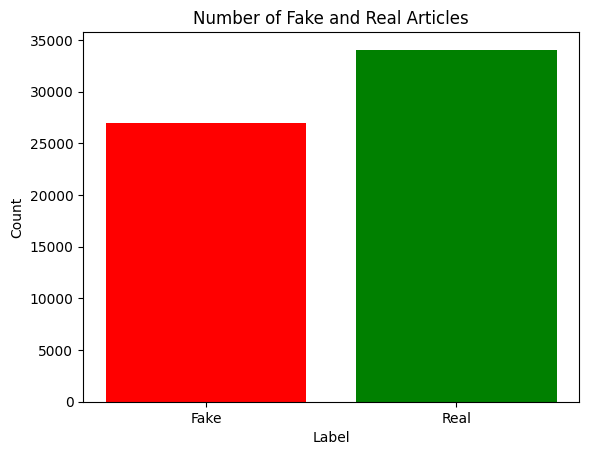

Total Fake Articles: 26975 (44.19%)
Total Real Articles: 34065 (55.81%)


In [25]:
# count occurances of fake and true data and plot
fake_count = df[df['label'] == 1].shape[0]
real_count = df[df['label'] == 0].shape[0]
total_articles = fake_count + real_count

plt.bar(['Fake', 'Real'], [fake_count, real_count], color=['red', 'green'])
plt.title('Number of Fake and Real Articles')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Print totals and percentages
fake_percentage = (fake_count / total_articles) * 100
real_percentage = (real_count / total_articles) * 100
print(f"Total Fake Articles: {fake_count} ({fake_percentage:.2f}%)")
print(f"Total Real Articles: {real_count} ({real_percentage:.2f}%)")

In [26]:
true_articles = df[df['label'] == 0]
fake_articles = df[df['label'] == 1]

real_count = len(fake_articles)
real_articles_sampled = true_articles.sample(n=real_count, random_state=42)

balanced_df = pd.concat([real_articles_sampled, fake_articles])
print(balanced_df['label'].value_counts())

label
0    26975
1    26975
Name: count, dtype: int64


# Statistical Analysis

In [27]:
# copying code from earlier dataset 
combined_data = balanced_df

In [28]:
spacy.cli.download('en_core_web_sm')
NER = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.4 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [29]:
# Randomly sample 5000 fake and 5000 true articles
sampled_fake = combined_data[combined_data['label'] == 1].sample(5000, random_state=42)
sampled_true = combined_data[combined_data['label'] == 0].sample(5000, random_state=42)

sampled_data = pd.concat([sampled_fake, sampled_true]).reset_index(drop=True)

In [30]:
# Function to count locations and people
def count_entities(text):
    doc = NER(" ".join(text))
    people = sum(1 for ent in doc.ents if ent.label_ == "PERSON")
    locations = sum(1 for ent in doc.ents if ent.label_ == "GPE")
    return people, locations

entity_counts = sampled_data['text_tokenized_filtered'].apply(count_entities)

sampled_data['person_count'] = [count[0] for count in entity_counts]
sampled_data['location_count'] = [count[1] for count in entity_counts]

sampled_data.head()

,title,text,label,text_tokenized,text_tokenized_filtered,person_count,location_count
0,Woman Arrested For DWI Has Jaw-Droppingly Stu...,"The cops should leave this woman, and all of h...",1,"[The, cops, should, leave, this, woman, ,, and...","[cops, leave, woman, people, alone, unless, do...",1,2
1,Responsible Gun Owner Shoots Himself After ‘A...,"On the night of January 7, 2016, responsible ...",1,"[On, the, night, of, January, 7, ,, 2016, ,, r...","[night, january, responsible, gun, owner, just...",11,1
2,Trump Marks D-Day Anniversary By Bragging Abo...,The first thing Donald Trump should have thoug...,1,"[The, first, thing, Donald, Trump, should, hav...","[first, thing, donald, trump, thought, tuesday...",5,12
3,Snowden Reveals How Easy It Is To Hack Voting ...,Share on Facebook Edward Snowden demonstrated ...,1,"[Share, on, Facebook, Edward, Snowden, demonst...","[share, facebook, edward, snowden, demonstrate...",11,17
4,ONE BRUTAL IMAGE Perfectly Captures The Truth ...,A spokesperson for the Clinton Foundation clai...,1,"[A, spokesperson, for, the, Clinton, Foundatio...","[spokesperson, clinton, foundation, claims, gr...",8,0


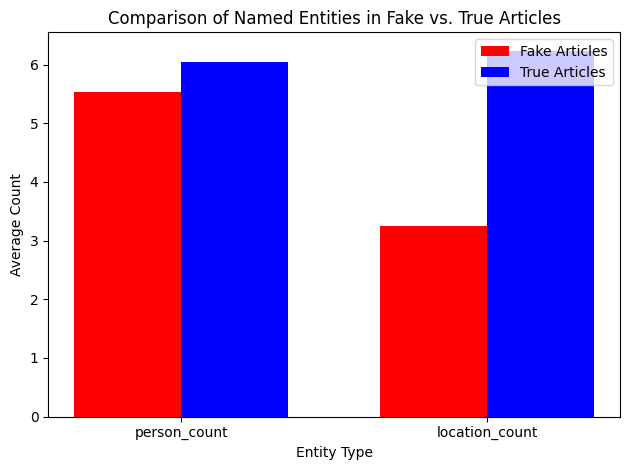

In [31]:
fake_stats = sampled_data[sampled_data['label'] == 1][['person_count', 'location_count']].mean()
true_stats = sampled_data[sampled_data['label'] == 0][['person_count', 'location_count']].mean()

categories = ['person_count', 'location_count']
fake_means = [fake_stats[cat] for cat in categories]
true_means = [true_stats[cat] for cat in categories]


x = np.arange(len(categories))
width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, fake_means, width, label='Fake Articles', color='red')
ax.bar(x + width/2, true_means, width, label='True Articles', color='blue')
ax.set_xlabel('Entity Type')
ax.set_ylabel('Average Count')
ax.set_title('Comparison of Named Entities in Fake vs. True Articles')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.tight_layout()
plt.show()

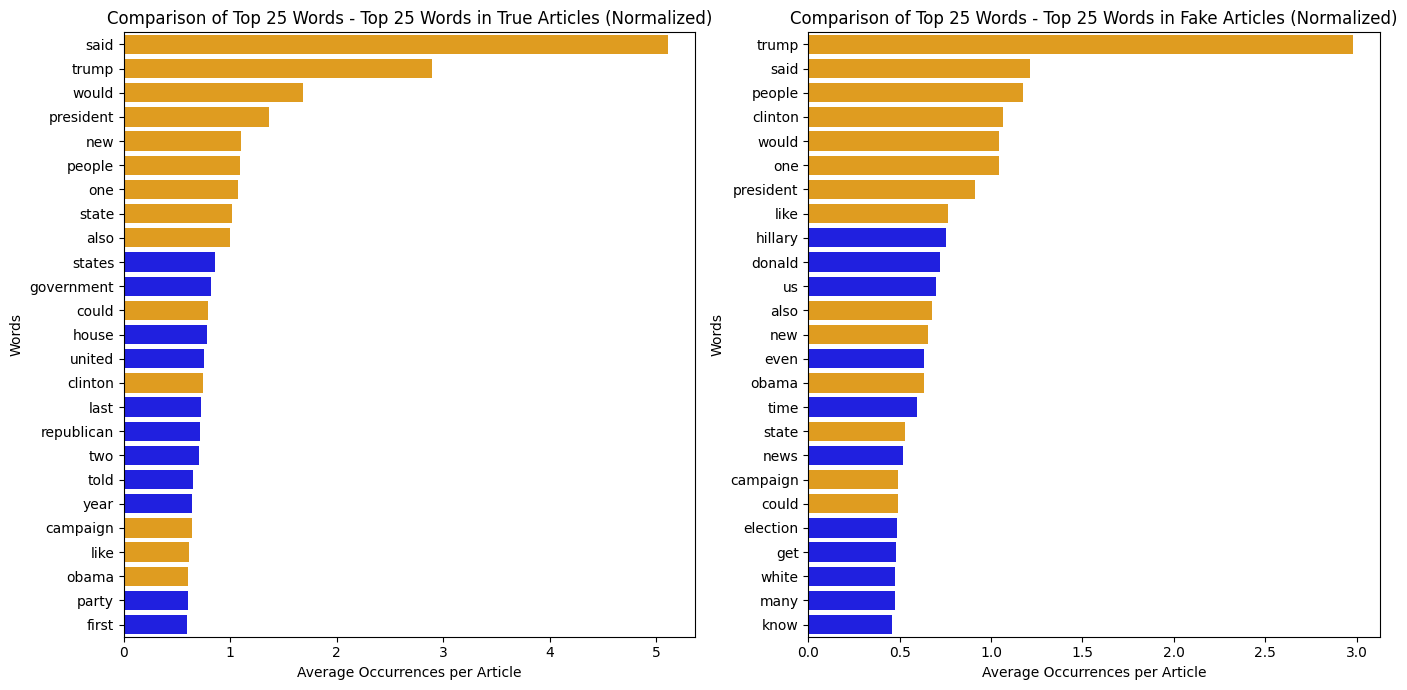

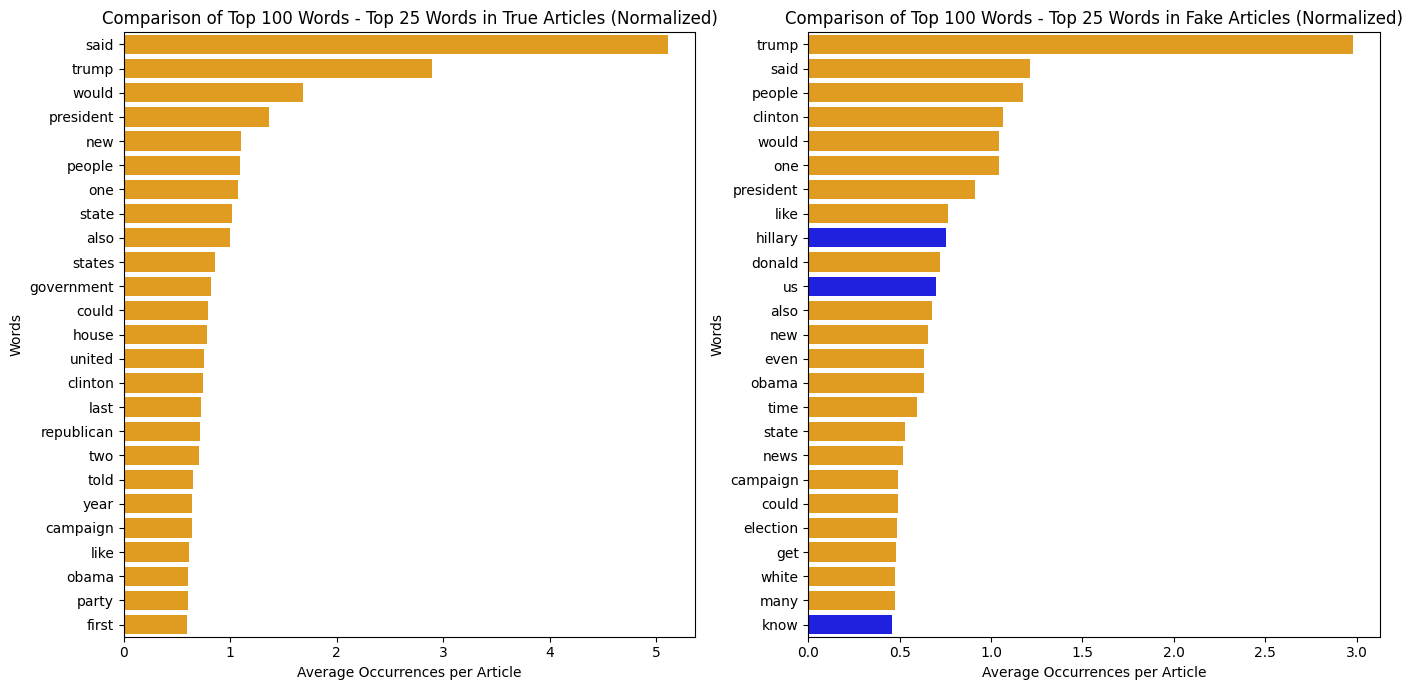

In [32]:
# Separate tokenized words by label then find top 25/top 100. find intersection of sets for overlap and graph
true_words = [word for tokens in combined_data[combined_data['label'] == 0]['text_tokenized_filtered'] for word in tokens]
fake_words = [word for tokens in combined_data[combined_data['label'] == 1]['text_tokenized_filtered'] for word in tokens]

true_word_counts = Counter(true_words)
fake_word_counts = Counter(fake_words)


def graph_common_words(num_depth, base_title):
    true_top_25 = true_word_counts.most_common(num_depth)
    fake_top_25 = fake_word_counts.most_common(num_depth)
    
    true_top_25_dict = dict(true_top_25)
    fake_top_25_dict = dict(fake_top_25)
    
    common_words = set(true_top_25_dict.keys()).intersection(fake_top_25_dict.keys())
    
    def prepare_data_for_plot(top_words, common_words):
        words, counts, colors = [], [], []
        for word, count in top_words:
            words.append(word)
            counts.append(count)
            colors.append('orange' if word in common_words else 'blue')
        return words, counts, colors
    
    # graph by average number of occurances per article
    def average_word_occurrence(word_counts, num_articles):
        return {word: count / num_articles for word, count in word_counts.items()}
    
    true_article_count = len(combined_data[combined_data['label'] == 0])
    fake_article_count = len(combined_data[combined_data['label'] == 1])
    
    true_avg_word_occurrence = average_word_occurrence(true_word_counts, true_article_count)
    fake_avg_word_occurrence = average_word_occurrence(fake_word_counts, fake_article_count)
    
    true_top_25_avg = sorted(true_avg_word_occurrence.items(), key=lambda x: x[1], reverse=True)[:25]
    fake_top_25_avg = sorted(fake_avg_word_occurrence.items(), key=lambda x: x[1], reverse=True)[:25]
    
    true_words_avg, true_counts_avg, true_colors = prepare_data_for_plot(true_top_25_avg, common_words)
    fake_words_avg, fake_counts_avg, fake_colors = prepare_data_for_plot(fake_top_25_avg, common_words)
    
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x=true_counts_avg, y=true_words_avg, hue=true_words_avg, palette=true_colors, legend=False)
    plt.title(base_title + ' - Top 25 Words in True Articles (Normalized)')
    plt.xlabel('Average Occurrences per Article')
    plt.ylabel('Words')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=fake_counts_avg, y=fake_words_avg, hue=fake_words_avg, palette=fake_colors, legend=False)
    plt.title(base_title + ' - Top 25 Words in Fake Articles (Normalized)')
    plt.xlabel('Average Occurrences per Article')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()


graph_common_words(25, "Comparison of Top 25 Words")
graph_common_words(100, "Comparison of Top 100 Words")

# Create Logistic Regression Model

In [33]:
tokenized_texts = combined_data['text_tokenized_filtered']

EMBEDDING_DIM = 100  # size of embeddings
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

def document_embedding(tokens, model):
    """Compute document embedding by averaging word embeddings."""
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(EMBEDDING_DIM)

document_embeddings = np.array([document_embedding(doc, w2v_model) for doc in tokenized_texts])

y = combined_data['label'].values
X_train, X_test, y_train, y_test = train_test_split(document_embeddings, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# evaluate
y_pred = logistic_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8626506024096385
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      5399
           1       0.86      0.86      0.86      5391

    accuracy                           0.86     10790
   macro avg       0.86      0.86      0.86     10790
weighted avg       0.86      0.86      0.86     10790



# Testing with test dataset

In [34]:
# Download latest version
path = kagglehub.dataset_download("rajatkumar30/fake-news")

print("Path to dataset files:", path)

Path to dataset files: /Users/skim/.cache/kagglehub/datasets/rajatkumar30/fake-news/versions/1


In [37]:
test_data_path = '/Users/skim/VSCode/DIS Copenhagen/Computational Analysis of Big Data/Final Project/news.csv'
test_data = pd.read_csv(test_data_path)

Had to switch the 1s to be fake and 0s to be true as the new model is above to get accurate metrics. 

In [38]:
test_data.drop(columns=['Unnamed: 0'], inplace=True)  # Drop random column

test_data['label'] = test_data['label'].map({'FAKE': 0, 'REAL': 1})  # again FAKE to 0 and REAL to 1
test_data['label'] = test_data['label'].apply(lambda x: 1 if x == 0 else 0)
test_data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [39]:
test_data['text_tokenized'] = test_data['text'].apply(word_tokenize)
test_data['text_tokenized_filtered'] = test_data['text_tokenized'].apply(filter_tokens)
test_data['text_tokenized_filtered'] = test_data['text_tokenized_filtered'].apply( lambda x: [word.lower() for word in x])

In [40]:
test_data.head()

,title,text,label,text_tokenized,text_tokenized_filtered
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,"[Daniel, Greenfield, ,, a, Shillman, Journalis...","[daniel, greenfield, shillman, journalism, fel..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,"[Google, Pinterest, Digg, Linkedin, Reddit, St...","[google, pinterest, digg, linkedin, reddit, st..."
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,"[U.S., Secretary, of, State, John, F., Kerry, ...","[secretary, state, john, kerry, said, monday, ..."
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,"[—, Kaydee, King, (, @, KaydeeKing, ), Novembe...","[kaydee, king, kaydeeking, november, lesson, t..."
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,"[It, 's, primary, day, in, New, York, and, fro...","[primary, day, new, york, hillary, clinton, do..."


In [41]:
test_embeddings = np.array([document_embedding(tokens, w2v_model) for tokens in test_data['text_tokenized_filtered']])

y_true = test_data['label'].values
y_pred = logistic_model.predict(test_embeddings)

# evaluate
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

print("Accuracy on the test dataset:", accuracy)
print("\nClassification Report:\n", report)

Accuracy on the test dataset: 0.7535911602209945

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73      3171
           1       0.72      0.84      0.77      3164

    accuracy                           0.75      6335
   macro avg       0.76      0.75      0.75      6335
weighted avg       0.76      0.75      0.75      6335



Much better accuracy on this test dataset!

# Testing with initial dataset

In [42]:
# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/skim/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1


Here I used a mv command in the terminal to move them both to a folder named data

In [43]:
# import fake csv
file_path = '/Users/skim/VSCode/DIS Copenhagen/Computational Analysis of Big Data/Final Project/Fake.csv'
test_fake_data = pd.read_csv(file_path)

In [44]:
# import true csv
true_path = '/Users/skim/VSCode/DIS Copenhagen/Computational Analysis of Big Data/Final Project/True.csv'
test_true_data = pd.read_csv(true_path)

In [45]:
test_fake_data['label'] = 1  # 1 for fake data
test_true_data['label'] = 0  # 0 for true data

test_combined_data = pd.concat([fake_data, true_data], ignore_index=True)

In [46]:
test_combined_data['text_tokenized'] = test_combined_data['text'].apply(word_tokenize)
test_combined_data['text_tokenized_filtered'] = test_combined_data['text_tokenized'].apply(filter_tokens)
test_combined_data['text_tokenized_filtered'] = test_combined_data['text_tokenized_filtered'].apply( lambda x: [word.lower() for word in x])

In [47]:
test_combined_data.head()

,title,text,label,text_tokenized,text_tokenized_filtered
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[No, comment, is, expected, from, Barack, Obam...","[comment, expected, barack, obama, members, fu..."
1,NaN,Did they post their votes for Hillary already?,1,"[Did, they, post, their, votes, for, Hillary, ...","[post, votes, hillary, already]"
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[Now, ,, most, of, the, demonstrators, gathere...","[demonstrators, gathered, last, night, exercis..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[The, RS-28, Sarmat, missile, ,, dubbed, Satan...","[sarmat, missile, dubbed, satan, replace, flie..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[All, we, can, say, on, this, one, is, it, s, ...","[say, one, time, someone, sued, southern, pove..."


In [48]:
test_embeddings2 = np.array([document_embedding(tokens, w2v_model) for tokens in test_combined_data['text_tokenized_filtered']])

y_true2 = test_combined_data['label'].values
y_pred2 = logistic_model.predict(test_embeddings2)

# evaluate
accuracy2 = accuracy_score(y_true2, y_pred2)
report2 = classification_report(y_true2, y_pred2)

print("Accuracy on the test dataset:", accuracy2)
print("\nClassification Report:\n", report2)

Accuracy on the test dataset: 0.8528191968929885

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85     35028
           1       0.86      0.85      0.86     37067

    accuracy                           0.85     72095
   macro avg       0.85      0.85      0.85     72095
weighted avg       0.85      0.85      0.85     72095



Finally, we achieve an even better accuracy on our initial dataset! It seems this model has learned the differences much more accurately!

# Testing With Left vs. Right Dataset

Here we are going to perform the cross testing where we will analyze if the same trends the model picked out to form the analysis for true and fake are applicable for the analysis of left and right classification.

# Importing Data

Using Signal Ai's dataset of 1 million articles, we parsed through the articles by selecting various news publishers known for having biases towards left or right political beliefs. Using the received JSON file, we filtered for sources such that we get a population of approximately 2000 total articles, with 1000 having left-leaning bias and 1000 having right-leaning bias.

In [51]:
import pandas as pd
import json

file_path = '/Users/skim/VSCode/DIS Copenhagen/Computational Analysis of Big Data/Final Project/signalmedia-1m.jsonl'

left_sources = {"cnn", "the new york times", "vox.com", "msnbc", "buzzfeed", "the new yorker: news"}
right_sources = {"fox news", "breitbart.com", "theblaze.com - stories", "cbn.com - cbn news", "daily caller", "daily mail", "newsmax.com", "new york post", "the american conservative \u00bb daniel larison", "infowars", "redstate", "national review"}

left_rows = []
right_rows = []

with open(file_path, 'r') as file:
    for line in file:
        entry = json.loads(line)
        if entry.get('source', '').lower().strip() in left_sources:
            left_rows.append(entry)
        if entry.get('source', '').lower().strip() in right_sources:
            right_rows.append(entry)
        if len(left_rows) + len(right_rows) >= 3000:
            break

left_data = pd.DataFrame(left_rows)
left_data["label"] = 0 # 0 for left

right_data = pd.DataFrame(right_rows)
right_data["label"] = 1 # 1 for right

combined_data_LR = pd.concat([left_data, right_data], ignore_index=True)

In [52]:
left_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1075 non-null   object
 1   content     1075 non-null   object
 2   title       1075 non-null   object
 3   media-type  1075 non-null   object
 4   source      1075 non-null   object
 5   published   1075 non-null   object
 6   label       1075 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 58.9+ KB


In [53]:
right_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1098 non-null   object
 1   content     1098 non-null   object
 2   title       1098 non-null   object
 3   media-type  1098 non-null   object
 4   source      1098 non-null   object
 5   published   1098 non-null   object
 6   label       1098 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 60.2+ KB


In [54]:
combined_data_LR.head()

,id,content,title,media-type,source,published,label
0,693ae030-4239-4291-b248-dbf7c1696ff2,Georgia is set to execute its only woman on de...,Georgia Plans To Execute Its Only Woman On Dea...,News,BuzzFeed,2015-09-28T22:24:29Z,0
1,e7157bbf-6ad4-477d-a4e4-14a0bb9ad9f5,"Story highlights Family posts, ""We are devasta...",'Senseless loss of a beautiful life',News,CNN,2015-09-07T19:48:15Z,0
2,0ef6b514-620d-4e8a-9405-e390e16c6cd7,"Obama dropped in on ""The Late Show with Stephe...",Michelle Obama gives Stephen Colbert advice fo...,News,CNN,2015-09-29T10:33:00Z,0
3,96b993b2-320f-457a-bab2-6bc214c05013,"Story highlights Estonia, a neighbor of Russia...",U.S. stealth fighters visit Estonia,News,CNN,2015-09-07T18:09:09Z,0
4,c3a3224d-bae5-40e3-80f6-0ca74083beaf,Story highlights Swiss prosecutors open crimin...,FIFA boss Blatter facing criminal proceedings,News,CNN,2015-09-25T16:38:47Z,0


# Data Pre-processing

Same process as we did in the model creator

In [55]:
# STEP 1 TOKENIZE
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

test_text = combined_data_LR.iloc[0]['content']
test_tokenized = word_tokenize(test_text)

print(test_tokenized)

['Georgia', 'is', 'set', 'to', 'execute', 'its', 'only', 'woman', 'on', 'death', 'row', 'Tuesday', 'evening', '.', 'If', 'all', 'goes', 'according', 'to', 'the', 'state', '’', 's', 'plan', ',', 'Kelly', 'Gissendaner', 'will', 'be', 'the', 'first', 'woman', 'the', 'state', 'has', 'executed', 'in', '70', 'years', '.', 'She', 'was', 'sentenced', 'to', 'death', 'in', '1998', 'for', 'plotting', 'the', 'death', 'of', 'her', 'husband', ',', 'Douglas', 'Gissendaner', ',', 'with', 'her', 'boyfriend', '.', 'Gissendaner', 'drove', 'her', 'boyfriend', ',', 'Gregory', 'Owen', ',', 'to', 'her', 'house', ',', 'gave', 'him', 'the', 'murder', 'weapons', '—', 'a', 'nightstick', 'and', 'a', 'hunting', 'knife', '—', 'and', 'then', 'went', 'to', 'a', 'nightclub', 'with', 'friends', ',', 'according', 'to', 'court', 'documents', '.', 'Owen', 'ambushed', 'Douglas', 'and', 'forced', 'him', 'to', 'drive', 'his', 'car', 'to', 'a', 'remote', 'location', 'that', 'Gissendaner', 'chose', 'beforehand', '.', 'Once', '

In [56]:
combined_data_LR['text_tokenized'] = combined_data_LR['content'].apply(word_tokenize)
combined_data_LR.head()

,id,content,title,media-type,source,published,label,text_tokenized
0,693ae030-4239-4291-b248-dbf7c1696ff2,Georgia is set to execute its only woman on de...,Georgia Plans To Execute Its Only Woman On Dea...,News,BuzzFeed,2015-09-28T22:24:29Z,0,"[Georgia, is, set, to, execute, its, only, wom..."
1,e7157bbf-6ad4-477d-a4e4-14a0bb9ad9f5,"Story highlights Family posts, ""We are devasta...",'Senseless loss of a beautiful life',News,CNN,2015-09-07T19:48:15Z,0,"[Story, highlights, Family, posts, ,, ``, We, ..."
2,0ef6b514-620d-4e8a-9405-e390e16c6cd7,"Obama dropped in on ""The Late Show with Stephe...",Michelle Obama gives Stephen Colbert advice fo...,News,CNN,2015-09-29T10:33:00Z,0,"[Obama, dropped, in, on, ``, The, Late, Show, ..."
3,96b993b2-320f-457a-bab2-6bc214c05013,"Story highlights Estonia, a neighbor of Russia...",U.S. stealth fighters visit Estonia,News,CNN,2015-09-07T18:09:09Z,0,"[Story, highlights, Estonia, ,, a, neighbor, o..."
4,c3a3224d-bae5-40e3-80f6-0ca74083beaf,Story highlights Swiss prosecutors open crimin...,FIFA boss Blatter facing criminal proceedings,News,CNN,2015-09-25T16:38:47Z,0,"[Story, highlights, Swiss, prosecutors, open, ..."


In [57]:
# Filter out stopwords and non-alpha words
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def filter_tokens(tokens):
    return [word for word in tokens if word.casefold() not in stop_words and word.isalpha()]

combined_data_LR['text_tokenized_filtered'] = combined_data_LR['text_tokenized'].apply(filter_tokens)

combined_data_LR.head()

,id,content,title,media-type,source,published,label,text_tokenized,text_tokenized_filtered
0,693ae030-4239-4291-b248-dbf7c1696ff2,Georgia is set to execute its only woman on de...,Georgia Plans To Execute Its Only Woman On Dea...,News,BuzzFeed,2015-09-28T22:24:29Z,0,"[Georgia, is, set, to, execute, its, only, wom...","[Georgia, set, execute, woman, death, row, Tue..."
1,e7157bbf-6ad4-477d-a4e4-14a0bb9ad9f5,"Story highlights Family posts, ""We are devasta...",'Senseless loss of a beautiful life',News,CNN,2015-09-07T19:48:15Z,0,"[Story, highlights, Family, posts, ,, ``, We, ...","[Story, highlights, Family, posts, devastated,..."
2,0ef6b514-620d-4e8a-9405-e390e16c6cd7,"Obama dropped in on ""The Late Show with Stephe...",Michelle Obama gives Stephen Colbert advice fo...,News,CNN,2015-09-29T10:33:00Z,0,"[Obama, dropped, in, on, ``, The, Late, Show, ...","[Obama, dropped, Late, Show, Stephen, Colbert,..."
3,96b993b2-320f-457a-bab2-6bc214c05013,"Story highlights Estonia, a neighbor of Russia...",U.S. stealth fighters visit Estonia,News,CNN,2015-09-07T18:09:09Z,0,"[Story, highlights, Estonia, ,, a, neighbor, o...","[Story, highlights, Estonia, neighbor, Russia,..."
4,c3a3224d-bae5-40e3-80f6-0ca74083beaf,Story highlights Swiss prosecutors open crimin...,FIFA boss Blatter facing criminal proceedings,News,CNN,2015-09-25T16:38:47Z,0,"[Story, highlights, Swiss, prosecutors, open, ...","[Story, highlights, Swiss, prosecutors, open, ..."


In [58]:
combined_data_LR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2173 entries, 0 to 2172
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       2173 non-null   object
 1   content                  2173 non-null   object
 2   title                    2173 non-null   object
 3   media-type               2173 non-null   object
 4   source                   2173 non-null   object
 5   published                2173 non-null   object
 6   label                    2173 non-null   int64 
 7   text_tokenized           2173 non-null   object
 8   text_tokenized_filtered  2173 non-null   object
dtypes: int64(1), object(8)
memory usage: 152.9+ KB


# Balance Classes

Again same process to balance the classes and filter the tokenized data

In [59]:
import matplotlib.pyplot as plt

# count occurances of right and left data and plot
right_count = combined_data_LR[combined_data_LR['label'] == 1].shape[0]
left_count = combined_data_LR[combined_data_LR['label'] == 0].shape[0]
total_articles = right_count + left_count

# Print totals and percentages
right_percentage = (right_count / total_articles) * 100
left_percentage = (left_count / total_articles) * 100
print(f"Total Right-Leaning Articles: {right_count} ({right_percentage:.2f}%)")
print(f"Total Left-Leaning Articles: {left_count} ({left_percentage:.2f}%)")

Total Right-Leaning Articles: 1098 (50.53%)
Total Left-Leaning Articles: 1075 (49.47%)


In [61]:
import random

# Randomly select the same number of right-leaning articles as left-leaning articles
right_data_subset = combined_data_LR[combined_data_LR['label'] == 1].sample(n=left_count, random_state=42)

# Combine the selected right-leaning data with the left-leaning data
combined_data_LR = pd.concat([combined_data_LR[combined_data_LR['label'] == 0], right_data_subset], ignore_index=True)

# Display the distribution of the new balanced dataset
print(combined_data_LR['label'].value_counts())

label
0    1075
1    1075
Name: count, dtype: int64


In [62]:
# Add a preprocessing step to convert all tokenized filtered words to lowercase
combined_data_LR['text_tokenized_filtered'] = combined_data_LR['text_tokenized_filtered'].apply(
    lambda x: [word.lower() for word in x]
)

# NOTE Delete code below - does not apply to signal ai dataset

# # Manually specify a set of stopwords that start with 'reuters'
# manual_stopwords = ['reuters', 'reuters.com', 'reutersnews', 'reutersnews.com']

# # Preprocessing step: Convert all tokenized filtered words to lowercase and remove stopwords
# combined_data_LR['text_tokenized_filtered'] = combined_data_LR['text_tokenized_filtered'].apply(
#     lambda x: [word.lower() for word in x if not any(word.startswith(stopword) for stopword in manual_stopwords)]
# )

# Cross-testing

Create embeddings to test as we have done before with the other datasets. then check for accuracy and print classification report

In [63]:
test_embeddings3 = np.array([document_embedding(tokens, w2v_model) for tokens in combined_data_LR['text_tokenized_filtered']])

y_true3 = combined_data_LR['label'].values
y_pred3 = logistic_model.predict(test_embeddings3)

# evaluate
accuracy3 = accuracy_score(y_true3, y_pred3)
report3 = classification_report(y_true3, y_pred3)

print("Accuracy on the test dataset:", accuracy3)
print("\nClassification Report:\n", report3)

Accuracy on the test dataset: 0.5060465116279069

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.47      0.49      1075
           1       0.51      0.55      0.52      1075

    accuracy                           0.51      2150
   macro avg       0.51      0.51      0.51      2150
weighted avg       0.51      0.51      0.51      2150



Not very interesting or conclusive results, we have very similar scores across classifications of fake or true for the different political articles which means the model found little to no connections between its understanding of semantics that classify fake or true applied to left vs right semantics. 